<a href="https://colab.research.google.com/github/estrella-celeste/ColabNoteboook/blob/main/EstrDiazU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Project by Estrella

#Introduction

For this project, I am going to use the penguin data set from the data folder. (Thanks Mr. Arredondo) I chose this data set because penguins are adorable and penguins is my friend's favorite animal.

In this project, I will create a model that captures the pattern of the data. From the data, I am going to use bill length and flipper length and how bill length affects flipper length.

In [1]:
#Import the necessary stuff
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

In [2]:
#Importing penguin data set
url_pen = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv'
penguin = pd.read_csv(url_pen)

In [3]:
#Penguin data
#dropna() removes missing values
penguin = penguin.dropna()
penguin

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


#Finding the likelihood

Before finding the likelihood, lets visualize the data.

<Axes: xlabel='bill_length', ylabel='flipper_length'>

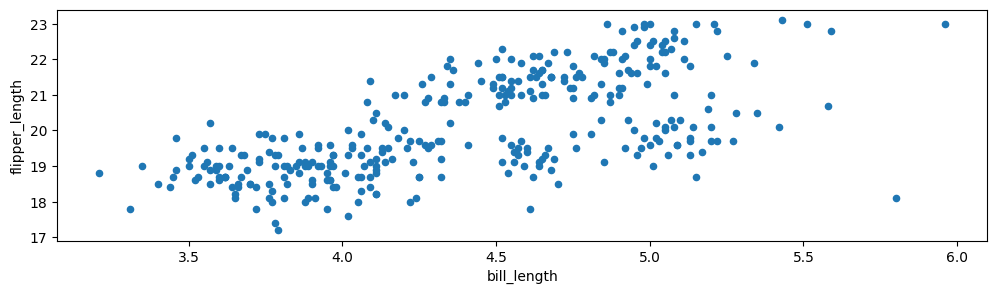

In [4]:
# Penguin Scatterplot
# x-axis = bill length
# y-axis = flipper length
penguin.plot(x="bill_length", y="flipper_length", figsize=(12, 3),kind="scatter")

The scatterplot seems like there could be a linear relationship between bill length and flipper lenght. There's a couple of outliers, but I think (hope?) that it won't affect the model.

Now I am going to find a likelihood using both the violin plot and histogram.

<Axes: ylabel='flipper_length'>

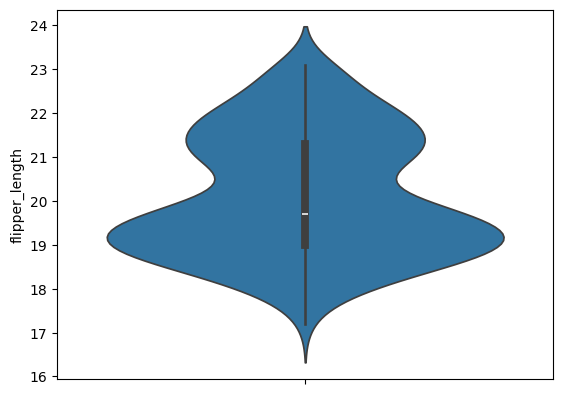

In [5]:
sns.violinplot(penguin.flipper_length)

(array([ 3., 20., 51., 77., 44., 15., 42., 38., 28., 15.]),
 array([17.2 , 17.79, 18.38, 18.97, 19.56, 20.15, 20.74, 21.33, 21.92,
        22.51, 23.1 ]),
 <BarContainer object of 10 artists>)

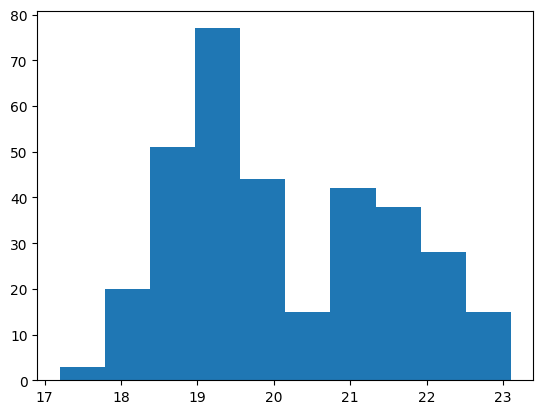

In [6]:
plt.hist(penguin.flipper_length)

Based on the shape, it is skewed right. I want to use the normal distribution.
The distribution may or may not fit the reality depending on the outcome of the model.

If normal distribution doesn't work then,then we can try LogNormal or other likelihood that can make the linear model portray best the data.

# Model using the Normal likelihood

## Model

In [7]:
#model
with pm.Model() as model_pen:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * penguin.bill_length)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=penguin.flipper_length)

    #inference data object
    idata_pn = pm.sample()

Output()

Output()

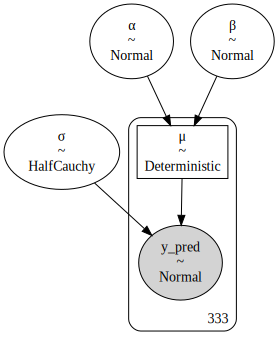

In [8]:
#Here to show what the model is doing
pm.model_to_graphviz(model_pen)

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

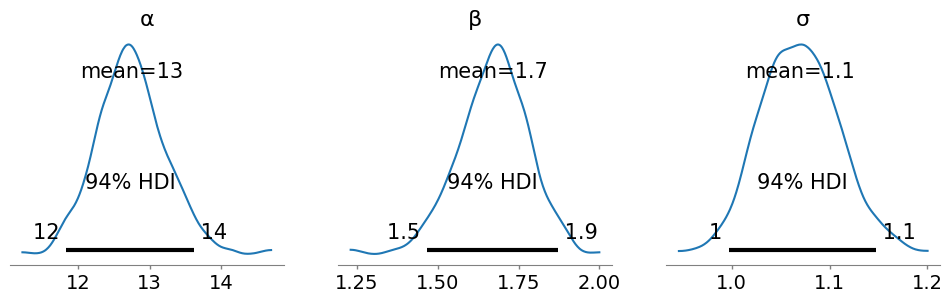

In [9]:
#plot of the posteriors for all the components of my line
#'~μ' means plot all variables except μ
az.plot_posterior(idata_pn, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'flipper length')

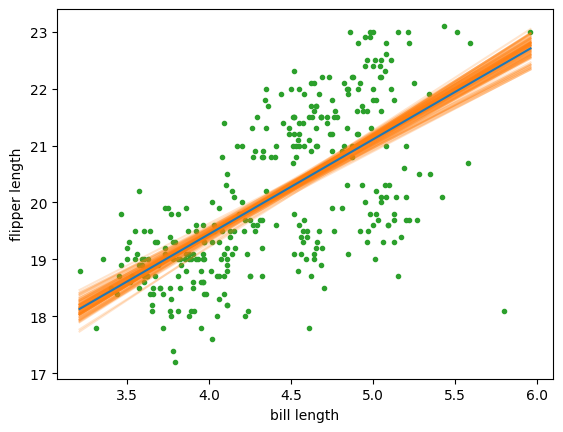

In [10]:
#grabs 100 posterior samples
posterior = az.extract(idata_pn, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(penguin.bill_length.min(), penguin.bill_length.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(penguin.bill_length, penguin.flipper_length, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("bill length")
ax.set_ylabel("flipper length")

The model managed to get a linear which is good. Though, the orange lines or predictions follow the black linear line though they have different slopes.

Now, let's see what the posterior predictive check has to say about this.

In [11]:
# posterior predictive check
pm.sample_posterior_predictive(idata_pn, model=model_pen,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'flipper_length')

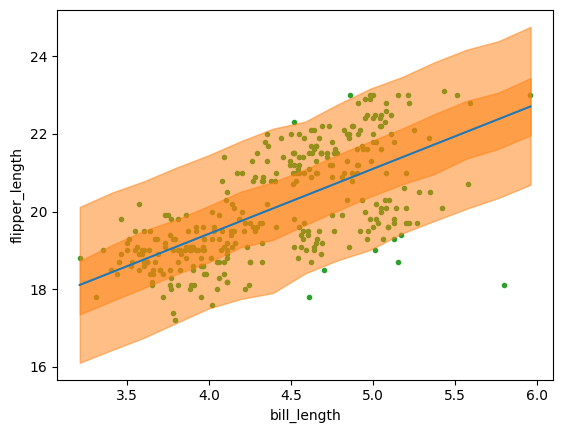

In [12]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_pn.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
billLength = np.random.normal(penguin.bill_length.values, 0.01)
idx = np.argsort(billLength)
x = np.linspace(billLength.min(), billLength.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_pn.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(billLength[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(penguin.bill_length, penguin.flipper_length, "C2.", zorder=-3)
#using DataFrame.to_numpy() in order to deal with dropped figures that messed up the indexes
ax.plot(penguin.bill_length.to_numpy()[idx], mean_line.to_numpy()[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("bill_length")
ax.set_ylabel("flipper_length")

<Axes: xlabel='y_pred'>

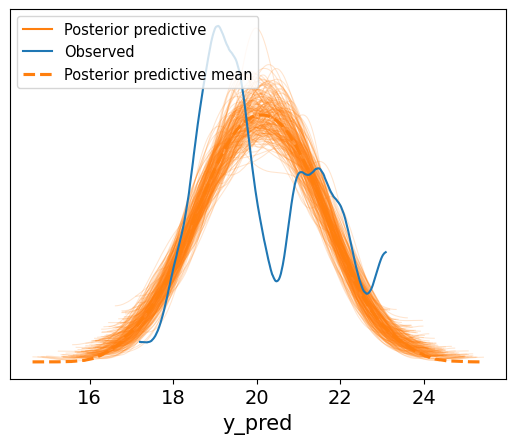

In [13]:
#posterior predictive check
az.plot_ppc(idata_pn, num_pp_samples=200, colors=["C1", "C0", "C1"])

## Observations

According the posterior predictive distribution, the model does manage to fit a linear model that fits the data.

The normal likelihood did work with the data and matches reality. Though the model isn't the best model. The posterior predictive lines aren't very clear at the top and aren't very centered to to the posterior predictive mean. Another thing, the posterior predictive mean sort of captures the shape of the observed data, the shape of the observed data is very weird. Based on the posterior predictve lines, the normal likelihood may not be the best likelihood to model this data.

# Model using the LogNormal likelihood

## Model

In [14]:
#model
with pm.Model() as model_peLn:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * penguin.bill_length)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.LogNormal("y_pred", mu=μ, sigma=σ, observed=penguin.flipper_length)

    #inference data object
    idata_pnLn = pm.sample()

Output()

Output()

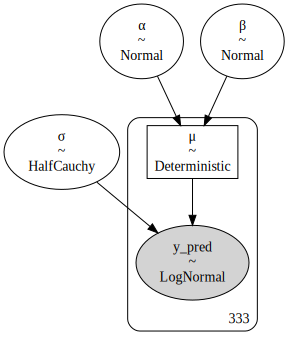

In [15]:
#Here to show what the model is doing
pm.model_to_graphviz(model_peLn)

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

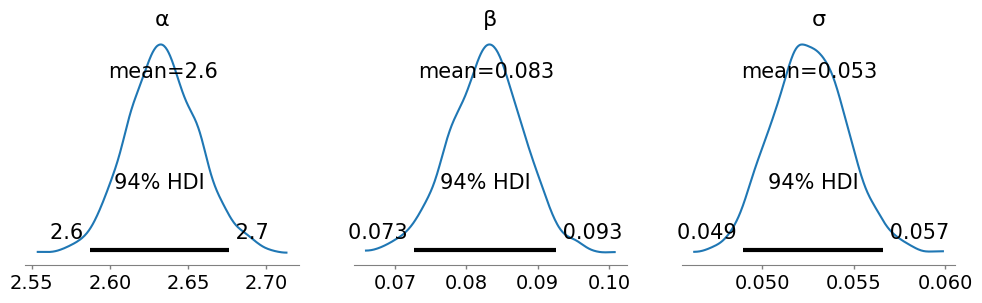

In [16]:
#plot of the posteriors for all the components of my line
#'~μ' means plot all variables except μ
az.plot_posterior(idata_pnLn, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'flipper length')

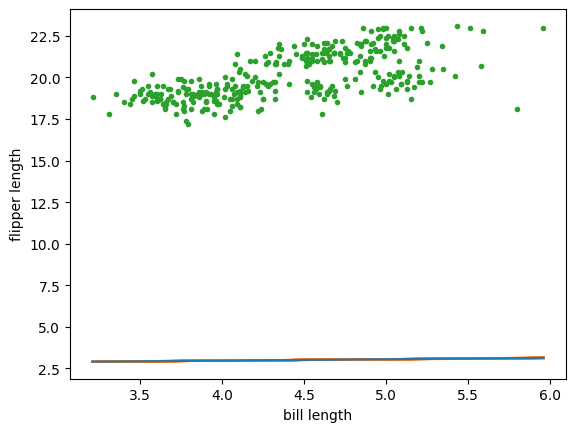

In [17]:
#grabs 100 posterior samples
posterior = az.extract(idata_pnLn, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(penguin.bill_length.min(), penguin.bill_length.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(penguin.bill_length, penguin.flipper_length, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("bill length")
ax.set_ylabel("flipper length")

Line looks wonky and doesn't portray the data. This is weird.

In [18]:
# posterior predictive check
pm.sample_posterior_predictive(idata_pnLn, model=model_peLn,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'flipper_length')

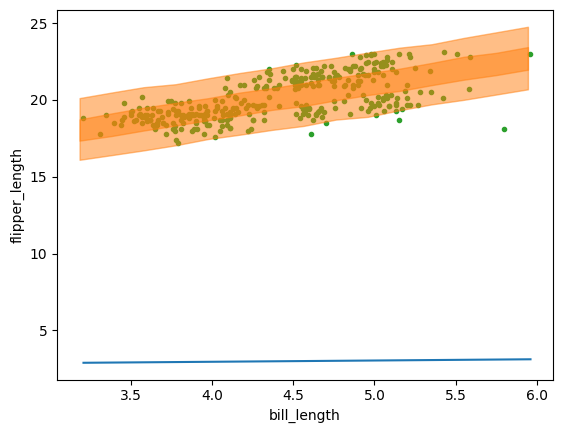

In [19]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_pnLn.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
billLength = np.random.normal(penguin.bill_length.values, 0.01)
idx = np.argsort(billLength)
x = np.linspace(billLength.min(), billLength.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_pn.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(billLength[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(penguin.bill_length, penguin.flipper_length, "C2.", zorder=-3)
#using DataFrame.to_numpy() in order to deal with dropped figures that messed up the indexes
ax.plot(penguin.bill_length.to_numpy()[idx], mean_line.to_numpy()[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("bill_length")
ax.set_ylabel("flipper_length")

<Axes: xlabel='y_pred'>

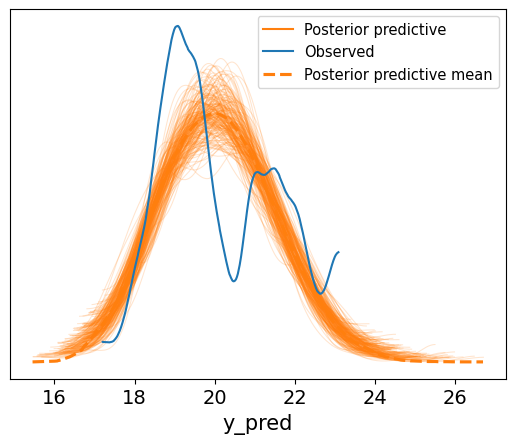

In [20]:
az.plot_ppc(idata_pnLn, num_pp_samples=200, colors=["C1", "C0", "C1"])

## Observations

It looks better but the posterior predictive distribution doesn't show the linear distribution on the data. Although, the posterior predictive lines still continue to show to be a bit uncertain. So, the LogNormal likelihood isn't the best likelihood.

# Model using Gamma likelihood

## Model

In [36]:
#model
with pm.Model() as model_peng:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * penguin.bill_length)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Gamma("y_pred", alpha=μ, beta=σ, observed=penguin.flipper_length)

    #inference data object
    idata_png = pm.sample()

Output()

Output()

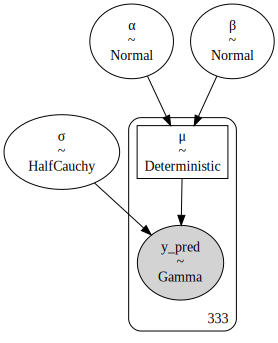

In [37]:
#Here to show what the model is doing
pm.model_to_graphviz(model_peng)

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

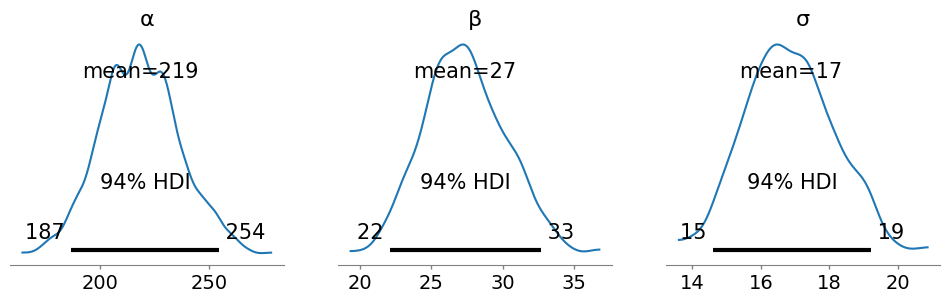

In [38]:
#plot of the posteriors for all the components of my line
#'~μ' means plot all variables except μ
az.plot_posterior(idata_png, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'flipper length')

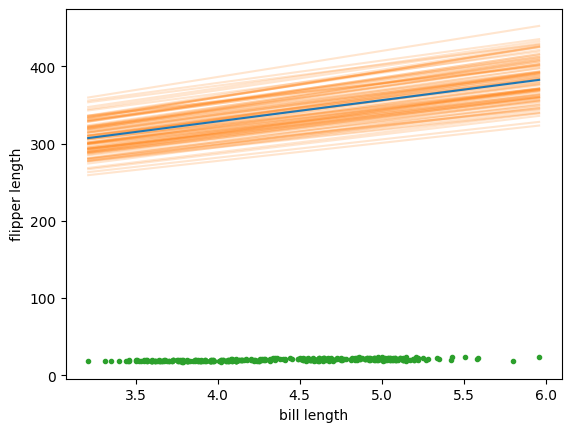

In [39]:
#grabs 100 posterior samples
posterior = az.extract(idata_png, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(penguin.bill_length.min(), penguin.bill_length.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(penguin.bill_length, penguin.flipper_length, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("bill length")
ax.set_ylabel("flipper length")

In [40]:
# posterior predictive check
pm.sample_posterior_predictive(idata_png, model=model_peng,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'flipper_length')

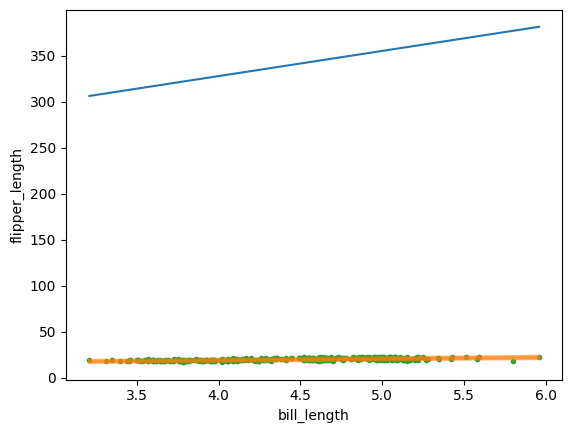

In [41]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_png.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
billLength = np.random.normal(penguin.bill_length.values, 0.01)
idx = np.argsort(billLength)
x = np.linspace(billLength.min(), billLength.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_png.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(billLength[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(penguin.bill_length, penguin.flipper_length, "C2.", zorder=-3)
#using DataFrame.to_numpy() in order to deal with dropped figures that messed up the indexes
ax.plot(penguin.bill_length.to_numpy()[idx], mean_line.to_numpy()[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("bill_length")
ax.set_ylabel("flipper_length")

<Axes: xlabel='y_pred'>

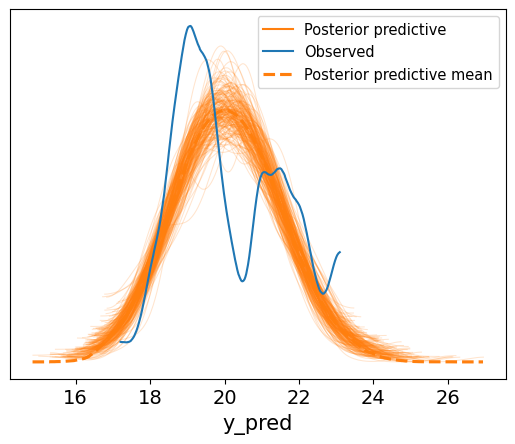

In [42]:
#posterior predictive check
az.plot_ppc(idata_png, num_pp_samples=200, colors=["C1", "C0", "C1"])

did not work

# Conclusion

The Normal likelihood was the one that worked the best. I think I am doing something wrong.